In [7]:
import pandas as pd
train = pd.read_csv("hotel_train.csv", index_col=0)
train

,Review,Stance,Hotel,Resource,Authenticity
0,"['hotel', 'staff', 'nice', 'many', 'inexperien...",negative,swissotel,Web,truthful
1,"['travel', 'hotel', 'family', 'vacation', 'cho...",negative,monaco,MTurk,deceptive
2,"['choose', 'talbott', 'hotel', 'primarily', 'l...",negative,talbott,MTurk,deceptive
3,"['travel', 'chicago', 'husband', 'romantic', '...",positive,sofitel,MTurk,deceptive
4,"['moment', 'step', 'front', 'entrance', 'luxur...",positive,fairmont,TripAdvisor,truthful
...,...,...,...,...,...
1275,"['room', 'big', 'luxurious', 'befit', 'price',...",negative,swissotel,Web,truthful
1276,"['wow', 'love', 'ambassador', 'east', 'hotel',...",positive,ambassador,MTurk,deceptive
1277,"['husband', 'love', 'hotel', 'staff', 'friendl...",positive,sheraton,MTurk,deceptive
1278,"['wife', 'stay', 'omni', 'hotel', 'chicago', '...",negative,omni,MTurk,deceptive


In [1]:
!pip3 install nltk
!pip3 install regex
!pip3 install scikit-learn==0.23.0

In [2]:
import html
from html.parser import HTMLParser
import nltk
import matplotlib.pyplot as mplt
import numpy as np
import pandas as pd
import pickle
import regex
import string
import time
import unicodedata
%matplotlib inline

from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.util import  mark_negation
from nltk.tokenize import TweetTokenizer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report as clsr
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhiyulin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zhiyulin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/zhiyulin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/zhiyulin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
class Preprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, lower=True, strip=True, remove_punct=True, 
                 remove_diacritics=True, unicode_form='NFC', remove_stop=False, 
                 stem_tokens=False, lemmatize_tokens=True, language='english'):
        self.lower = lower
        self.strip = strip
        self.remove_punct = remove_punct
        self.remove_diacritics = remove_diacritics
        self.set_unicode_form(unicode_form)
        self.remove_stop = remove_stop
        self.stem_tokens = stem_tokens
        self.lemmatize_tokens = lemmatize_tokens    
        self.stopwords  = set(nltk.corpus.stopwords.words(language))
        self.punct = set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = nltk.stem.SnowballStemmer(language) 
        self.tokenizer = TweetTokenizer()

    def transform(self, X):
        return [list(self.tokenize(doc)) for doc in X]

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]

    def fit(self, X, y=None):
        return self

    def set_stopwords(self, stopwords):
        self.stopwords  = stopwords or set(nltk.corpus.stopwords.words('english'))

    def set_punct(self, punct):
        self.punct      = punct or set(string.punctuation)

    def set_unicode_form(self, unicode_form):
        self.unicode_form = unicode_form.strip().upper()
        if not self.unicode_form in ['NFC','NFD','NFKC','NFKD']:
            self.unicode_form = 'NFC'

    def get_params(self):
        print("lower: ",self.lower)
        print("strip: ",self.strip)
        print("remove_punct: ",self.remove_punct)
        print("remove_diacritics: ",self.remove_diacritics)
        print("unicode_form: ",self.unicode_form)
        print("remove_stop: ",self.remove_stop)
        print("stem_tokens: ",self.stem_tokens)
        print("lemmatize_tokens",self.lemmatize_tokens)       
        print("lemmatizer: ",type(self.lemmatizer).__name__)
        print("stemmer: ",type(self.stemmer).__name__) 
        print("punctuation: ",self.punct)
        print("stopwords: ",self.stopwords)

    # convert nltk pos-tag to wordnet pos-tag
    # for use by the wordnet lemmatizer
    @staticmethod
    def get_wordnet_tag(nltk_tag):
        if nltk_tag.startswith('N'):
            return wn.NOUN
        elif nltk_tag.startswith('V'):
            return wn.VERB
        elif nltk_tag.startswith('J'):
            return wn.ADJ
        elif nltk_tag.startswith('R'):
            return wn.ADV
        else:          
            return None

    # determine whether a string is comprised of all punctuation-like characters
    def is_punct(self, text):
        if text in self.punctuation:
            return True
        if regex.match(r"[\p{P}\p{Mn}\p{Sk}]+", text):
            return True
        return False

    # normalize token strings
    def normalize_string(self, token):
        token = html.unescape(token)
        token = token.lower() if self.lower else token
        token = token.strip(' _*')  if self.strip else token

        if self.remove_diacritics:
            token = regex.sub("\p{Mn}",'',unicodedata.normalize('NFD',token)) 

        #not is in the stopword list, but n't isn'
        if token == "n't" and self.stopwords:
            token = "not"
      
        return unicodedata.normalize(self.unicode_form,token)

    # determine whether a string is comprised completely
    # of things that seem like punctuation
    def is_punct(self, text):
        if text in string.punctuation:
            return True
        if regex.match(r"^[\p{P}\p{Mn}\p{Sk}]+$", text):
            return True
        return False

    # tokenize the document with optional normalization
    def tokenize(self, document, all_fields=False):
        tokens = []
        for sent in sent_tokenize(document):
            cleaner_sent = html.unescape(sent)
            for token in nltk.pos_tag(self.tokenizer.tokenize(cleaner_sent)):
                stem = ''
                token_text = self.normalize_string(token[0])
                token_pos = token[1]
                if self.remove_punct and self.is_punct(token_text):
                #if remove_punct and token_text in string.punctuation:
                    continue
                if self.remove_stop and token_text in self.stopwords:
                    continue
                if self.stem_tokens or all_fields:
                    stem = self.stemmer.stem(token_text)
                if self.lemmatize_tokens or all_fields:
                    wordnet_tag = self.get_wordnet_tag(token_pos)
                    if wordnet_tag is not None:
                        lemma = self.lemmatizer.lemmatize(token_text,wordnet_tag)
                    else:
                        lemma = token_text
                if all_fields:
                    tokens.append({'token': token_text, 'stem': stem, 'lemma': lemma})
                elif self.stem_tokens:
                    tokens.append(stem)
                elif self.lemmatize_tokens:
                    tokens.append(lemma)
                else:
                    tokens.append(token_text)     
        return tokens

In [5]:
### This function gives me the tokens, the vocabulary, and the vocabulary for each target
vocabulary = {}
target_vocabularies = {}
def get_token_analysis(preprocessor, tweet_text, target=None):
    tokens = preprocessor.tokenize(tweet_text)
    for token in tokens:
        if token in vocabulary:
            vocabulary[token] += 1
        else:
            vocabulary[token] = 1
        if target:
            if target in target_vocabularies:
                target_dict = target_vocabularies[target]
                if token in target_dict:
                    target_dict[token] += 1
                else:
                    target_dict[token] = 1
                target_vocabularies[target] = target_dict
            else:
                target_vocabularies[target] = {token: 1} 
    return tokens 

In [13]:
### Call the previous function, initailize the preprocessor, and get the total number of tokens and tweet length
INPUT = train[['Review', 'Authenticity']]
num_tweets = 0
total_tokens = 0
review_lengths_in_tokens = []
my_preprocessor = Preprocessor(remove_punct=True, remove_stop=False, remove_diacritics=True, lemmatize_tokens=True)
all_tokens = []
for r in range(INPUT.shape[0]):
    row = INPUT.iloc[r]
    num_tweets += 1
    tokens = get_token_analysis(my_preprocessor, row.Review, row.Authenticity)
    all_tokens.append(tokens)
    review_lengths_in_tokens.append(len(tokens))
    total_tokens += len(tokens)

## Vocabulary per Authenticity

There are 7167 distinct words in the input data.


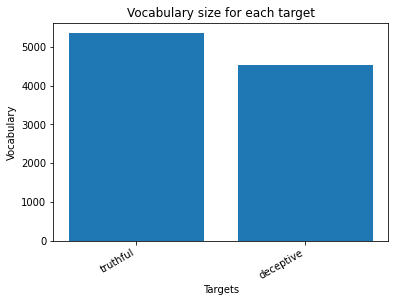

In [17]:
print("There are", len(vocabulary), 'distinct words in the input data.')

height = [len(target_vocabularies[k]) for k in target_vocabularies.keys()]
plt.bar(target_vocabularies.keys(), height)
plt.xticks(rotation=30, ha='right')
plt.xlabel('Targets')
plt.ylabel('Vocabulary')
plt.title('Vocabulary size for each target')
plt.show()

## Vocabulary per Stance

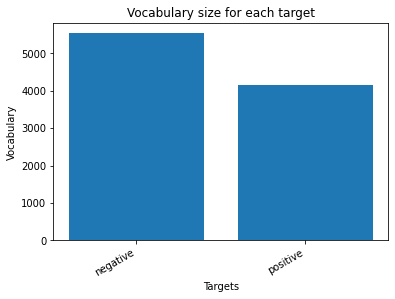

In [21]:
### Call the previous function, initailize the preprocessor, and get the total number of tokens and tweet length
INPUT = train[['Review', 'Stance']]
num_tweets = 0
total_tokens = 0
review_lengths_in_tokens = []
my_preprocessor = Preprocessor(remove_punct=True, remove_stop=False, remove_diacritics=True, lemmatize_tokens=True)
all_tokens = []
vocabulary = {}
target_vocabularies = {}
for r in range(INPUT.shape[0]):
    row = INPUT.iloc[r]
    num_tweets += 1
    tokens = get_token_analysis(my_preprocessor, row.Review, row.Stance)
    all_tokens.append(tokens)
    review_lengths_in_tokens.append(len(tokens))
    total_tokens += len(tokens)

height = [len(target_vocabularies[k]) for k in target_vocabularies.keys()]
plt.bar(target_vocabularies.keys(), height)
plt.xticks(rotation=30, ha='right')
plt.xlabel('Targets')
plt.ylabel('Vocabulary')
plt.title('Vocabulary size for each target')
plt.show()

## Vocabulary per Authenticity per Stance

In [25]:
target = train['Authenticity'].tolist()
stance = train['Stance'].tolist()
combined_target = []
for i, e in enumerate(target):
    combined_target.append(e + "_" + stance[i])
train['combined_target'] = combined_target

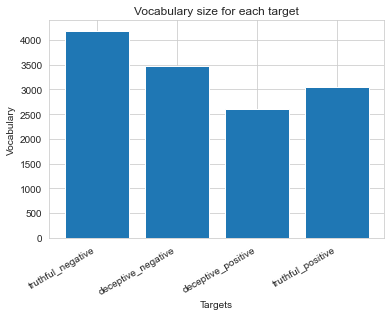

In [39]:
### Call the previous function, initailize the preprocessor, and get the total number of tokens and tweet length
INPUT = train[['Review', 'combined_target']]
num_tweets = 0
total_tokens = 0
review_lengths_in_tokens = []
truthful_negative, deceptive_negative, deceptive_positive, truthful_positive= [], [], [], []
my_preprocessor = Preprocessor(remove_punct=True, remove_stop=False, remove_diacritics=True, lemmatize_tokens=True)
all_tokens = []
vocabulary = {}
target_vocabularies = {}
for r in range(INPUT.shape[0]):
    row = INPUT.iloc[r]
    num_tweets += 1
    tokens = get_token_analysis(my_preprocessor, row.Review, row.combined_target)
    all_tokens.append(tokens)
    review_lengths_in_tokens.append(len(tokens))
    if row.combined_target == 'truthful_negative':
        truthful_negative.append(len(tokens))
    elif row.combined_target == 'deceptive_negative':
        deceptive_negative.append(len(tokens))
    elif row.combined_target == 'deceptive_positive':
        deceptive_positive.append(len(tokens))
    else:
        truthful_positive.append(len(tokens))
    total_tokens += len(tokens)

height = [len(target_vocabularies[k]) for k in target_vocabularies.keys()]
plt.bar(target_vocabularies.keys(), height)
plt.xticks(rotation=30, ha='right')
plt.xlabel('Targets')
plt.ylabel('Vocabulary')
plt.title('Vocabulary size for each target')
plt.show()

Average number of words in each review: 73.77265625
Standard deviation of number of words in each review: 43.02164102018118 



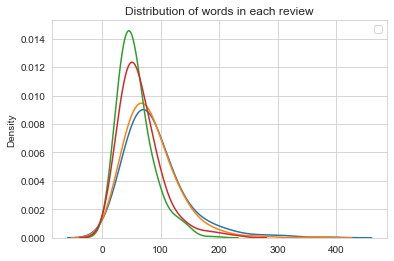

In [41]:
import numpy as np
import seaborn as sns
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings("ignore")

label_patches = []

print("Average number of words in each review:", np.mean(review_lengths_in_tokens))
print("Standard deviation of number of words in each review:", np.std(review_lengths_in_tokens), '\n')
sns.set_style('whitegrid')
sns.kdeplot(np.array(truthful_negative), bw=0.5)
sns.kdeplot(np.array(deceptive_negative), bw=0.5)
sns.kdeplot(np.array(deceptive_positive), bw=0.5)
sns.kdeplot(np.array(truthful_positive), bw=0.5)
plt.title('Distribution of words in each review')
plt.legend(handles=label_patches, loc='upper right')
plt.show()
    